Sergi Busquets (https://github.com/seeergiii)

# AB Testing: Server Efficiency Analysis

In the bustling IT department of a corporate office, they faced the task of assessing the performance of their web servers efficiently. With a methodical approach, they decided to measure the wait times between client requests and server responses. In a routine task that mirrored their daily operations, they recorded the **wait times in milliseconds for two servers**, TA and TB, over a fixed number of requests. The data points collected were organized in a file named 'ActR08TATB.csv', ready for analysis.

**Data Source:** Universitat Oberta de Catalunya (UOC)

## 1️⃣ Test whether we can consider server A to be less efficient than server B, using a significance level at α = 0.01.

### Data overview

Let's first import the necessary libraries for data manipulation, statistics, and visualization. We wiil read the raw data from the CSV file named ActR08TATB.csv using Pandas.

In [444]:
# Import libraries
import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

In [445]:
# Read .csv file
data = pd.read_csv('raw_data/ActR08TATB.csv', delimiter=';')
data.head(5)

,TA,TB
0,9.67,6.45
1,9.62,9.64
2,9.50,8.53
3,10.88,9.20
4,8.94,4.55


We create a boxplot to visually compare the response times of both servers. The boxplot shows the median, quartiles, and outliers for each server.

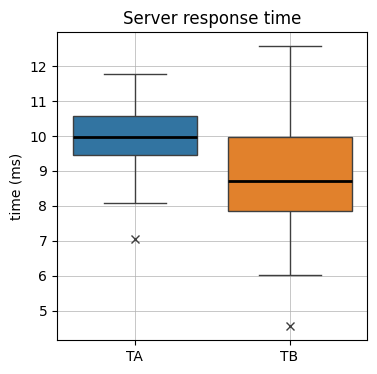

In [446]:
# Boxplots for response times on each server
plt.figure(figsize=(4, 4))
ax = sns.boxplot(data=data,
                 flierprops={"marker": "x"},
                 medianprops={"color": "black", "linewidth": 2})
plt.grid(lw=0.5)
plt.title('Server response time')
plt.ylabel('time (ms)')
plt.show()

We can see how the server response time is faster on requests made to server TA compared to the ones made to server TB. The median response time for server TA is around 10 ms, while the median response time for server TB is about 8.5 ms.

The spread of the response times is larger for server TB, as the whiskers extend from 6 ms to over 12 ms, while the whiskers for server TA extend from 8 ms to just below 12 ms. This shows that there is a wider range of response times on server TB than on server TA.

There are only two outliers detected for server TA, and one outlier for server TB.

### Hypothesis statements

**H<sub>0</sub>:** x̄<sub>A</sub> - x̄<sub>B</sub> = 0

**H<sub>a</sub>:** x̄<sub>A</sub> - x̄<sub>B</sub> > 0


### Test statistic:

In [447]:
mean_ta = data.TA.mean()
mean_tb = data.TB.mean()

variance_ta = data.TA.var()
variance_tb = data.TB.var()

In [448]:
z = (mean_ta - mean_tb) / (sqrt((variance_ta/len(data.TA) + variance_tb/len(data.TB))))
z

3.7134080154690747

### P-value:

In [449]:
from scipy.stats import norm
1-norm.cdf(z)

0.0001022434048687515

## 2️⃣ Find a 99% confidence interval for the wait time difference between the two servers, assuming equal variances.

In [450]:
from scipy import stats
z = norm.ppf(.005)
z

-2.575829303548901

In [451]:
m = z * sqrt((variance_ta/len(data.TA))+(variance_tb/len(data.TB)))
m

-0.715992154928153

In [452]:
bottom = (mean_ta-mean_tb) + m
bottom

0.3162078450718483

In [453]:
top = (mean_ta-mean_tb) - m
top

1.7481921549281543

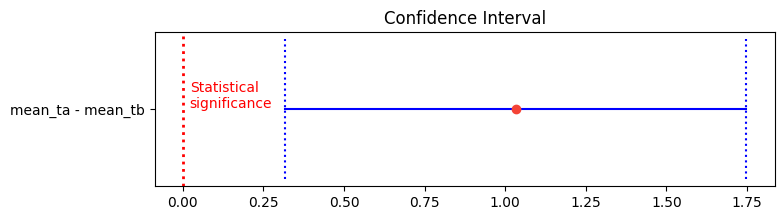

In [454]:
def plot_confidence_interval(x, top, central, bottom, color='blue', horizontal_line_width=0.25):
    left_w = x - horizontal_line_width / 4
    right_w = x + horizontal_line_width / 4
    plt.plot([top, bottom], [x, x], color=color)
    plt.plot([top, top], [left_w, right_w], color=color, linestyle='dotted')
    plt.plot([bottom, bottom], [left_w, right_w], color=color, linestyle='dotted')
    plt.plot(central, x, 'o', color='#f44336')

plt.figure(figsize=(8, 2))
plt.title('Confidence Interval')
plt.yticks([1], ['mean_ta - mean_tb'])
plt.axvline(x=0, color='red', linestyle='dotted', lw=2)
plt.annotate('Statistical\nsignificance', xy=(0, 1), xytext=(5, 1), textcoords='offset points', color='red')
plot_confidence_interval(1, top, (mean_ta - mean_tb), bottom)
plt.show()

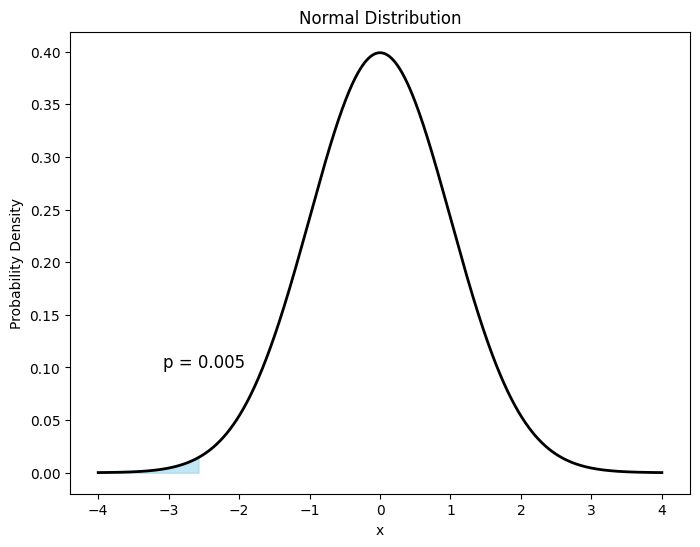

In [455]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the mean and standard deviation of the normal distribution
mu = 0
sigma = 1

# Define the p-value
p_value = 0.005
# Calculate the z-score corresponding to the p-value
z_score = norm.ppf(p_value)


x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 6))
plt.plot(x, y, 'k-', linewidth=2)
# Shade the area under the curve for the left tail
x_fill = np.linspace(-4, z_score, 100)
y_fill = norm.pdf(x_fill, mu, sigma)
plt.fill_between(x_fill, y_fill, color='skyblue', alpha=0.5)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Normal Distribution')
plt.text(z_score - 0.5, 0.1, f'p = {p_value}', fontsize=12)
plt.show()


## 3️⃣ The company has considered that a wait time is acceptable if it remains under 9 milliseconds. Can we say that the proportion of requests with acceptable wait times is different for the two servers, using a confidence level at α = 0.05?

In [456]:
tolerated_time = lambda x: 1 if x < 9 else 0
data['TA_tolerated'] = data['TA'].apply(tolerated_time)
data['TB_tolerated'] = data['TB'].apply(tolerated_time)

data.head(5)

,TA,TB,TA_tolerated,TB_tolerated
0,9.67,6.45,0,1
1,9.62,9.64,0,0
2,9.50,8.53,0,1
3,10.88,9.20,0,0
4,8.94,4.55,1,1


In [ ]:
pa = len(data[data['TA_tolerated'] == 1]) / len(data.TA_tolerated)
pb = len(data[data['TB_tolerated'] == 1]) / len(data.TB_tolerated)
pa
pb

0.62

In [ ]:
p_pool = (len(data.TA_tolerated) * pa + len(data.TB_tolerated) * pb) / (len(data.TA_tolerated) + len(data.TB_tolerated))
p_pool

0.37

In [ ]:
z = (pa - pb) / (sqrt(p_pool * (1-p_pool) * (1/len(data.TA_tolerated) + 1/len(data.TB_tolerated))))
z

-5.178081383343334

In [ ]:
2*norm.cdf(z)

2.2417943998316116e-07

reject null hypothesis

bootstraped proportion

In [ ]:
# permutation test
import random

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = list(random.sample(range(n), nB))
    idx_A = list(set(range(n)) - set(idx_B))
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

Observed difference: -50.0%


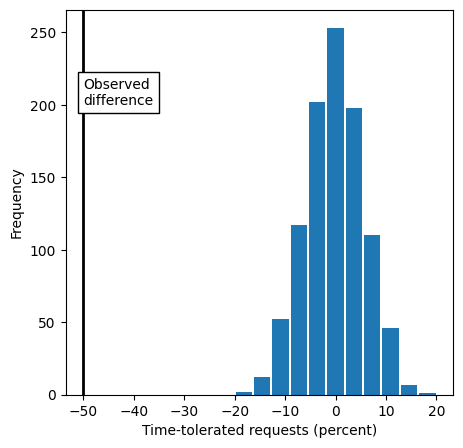

In [ ]:
obs_pct_diff = (pa - pb) * 100
print(f'Observed difference: {obs_pct_diff}%')

tolerated = [0] * (len(data[data['TA_tolerated'] == 0]) + len(data[data['TA_tolerated'] == 0]))
tolerated.extend([1] * (len(data[data['TA_tolerated'] == 1]) + len(data[data['TA_tolerated'] == 1])))
tolerated = pd.Series(tolerated)

perm_diffs = [100 * perm_fun(tolerated, int(len(data.TA_tolerated)), int(len(data.TB_tolerated)))
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(obs_pct_diff, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Time-tolerated requests (percent)')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
# frequency with which the chance model produces a result more extreme than the observed result
# P VALUE
np.mean([diff >= abs(obs_pct_diff) for diff in perm_diffs])

0.0